In [1]:
'''
 # @ Create date: 2022-01-13
 # @ Modified by: Gil
 # @ Modified date: 2024-10-29
 # @ Description: This file implements functions from the pricing module to show how to get the price and yield of a trade.
 '''
# ensures that any changes to the modules will be reloaded when this cell is run
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np

from google.cloud import bigquery

from ficc.utils.auxiliary_functions import sqltodf
from ficc.utils.process_features import process_features
from ficc.pricing.price import compute_price
from ficc.pricing.yield_rate import compute_yield

/Users/gil/git/ficc/notebooks/solve/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Initializing pandarallel with 4 cores
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/gil/git/ficc/creds.json'

In [ ]:
query = ''' WITH ranked_predictions AS (
  SELECT 
    *,
    ROW_NUMBER() OVER(PARTITION BY rtrs_control_number ORDER BY prediction_datetime DESC) AS rn
  FROM 
    `historic_predictions.historical_predictions_similar_trades`
)
SELECT
  pred.cusip,
  pred.rtrs_control_number,
  trades.trade_datetime,
  pred.new_ficc_ycl + new_ys_prediction as ficc_ytw,
  trades.coupon,
  trades.trade_type,
  trades.settlement_date,
  trades.trade_date,
  trades.par_traded,
  trades.accrual_date,
  trades.dollar_price,
  trades.issue_price,
  trades.interest_payment_frequency,
  trades.next_call_date,
  trades.par_call_date,
  trades.next_call_price,
  trades.par_call_price,
  trades.maturity_date,
  trades.previous_coupon_payment_date,
  trades.next_coupon_payment_date,
  trades.first_coupon_date,
  trades.coupon_type,
  trades.muni_security_type,
  trades.called_redemption_type,
  trades.refund_date,
  trades.refund_price,
  trades.is_callable,
  trades.is_called,
  trades.call_timing,
  trades.has_zero_coupons,
  trades.last_period_accrues_from_date,
  trades.call_defeased,
  trades.issue_amount,
  trades.maturity_amount,
  trades.orig_principal_amount,
  trades.max_amount_outstanding,
  trades.delivery_date,
  trades.next_sink_date,
  trades.dated_date,
  trades.MSRB_valid_to_date
  FROM 
  ranked_predictions pred
LEFT JOIN
  `auxiliary_views_v2.trade_history_same_issue_5_yr_mat_bucket_1_materialized` trades
ON
  pred.rtrs_control_number = trades.rtrs_control_number
WHERE
  pred.trade_date > '2024-07-01'
  AND trades.MSRB_valid_to_date > current_datetime
  AND trades.interest_payment_frequency IN (1, 16, 2, 3, 5)
  and rn = 1
ORDER BY
  trades.trade_datetime DESC
'''

In [4]:
muni_df_query = query

using_saved_muni_df = False
MUNI_DF_FILE_NAME = 'muni_df_and_query.pkl'
if os.path.exists(MUNI_DF_FILE_NAME):
    with open(MUNI_DF_FILE_NAME, 'rb') as file:
        muni_df_query_from_pkl, muni_df = pickle.load(file)
    if muni_df_query == muni_df_query_from_pkl:
        using_saved_muni_df = True

if not using_saved_muni_df:
    bqclient = bigquery.Client()
    muni_df = sqltodf(muni_df_query, bqclient)
    with open(MUNI_DF_FILE_NAME, 'wb') as file:
        pickle.dump((muni_df_query, muni_df), file)

In [5]:
muni_df

,cusip,rtrs_control_number,trade_datetime,ficc_ytw,coupon,trade_type,settlement_date,trade_date,par_traded,accrual_date,...,last_period_accrues_from_date,call_defeased,issue_amount,maturity_amount,orig_principal_amount,max_amount_outstanding,delivery_date,next_sink_date,dated_date,MSRB_valid_to_date
0,078043PL4,2024102816167200,2024-10-28 19:56:03,311.511528,5.000,D,2024-10-29,2024-10-28,10000.000000000,2023-04-13,...,2027-01-10,None,48505000.0,2115000.0,2115000.0,2115000,2023-04-13,NaT,2023-04-13,2100-01-01
1,078043PL4,2024102816167100,2024-10-28 19:56:03,301.918285,5.000,S,2024-10-29,2024-10-28,10000.000000000,2023-04-13,...,2027-01-10,None,48505000.0,2115000.0,2115000.0,2115000,2023-04-13,NaT,2023-04-13,2100-01-01
2,646139A96,2024102816166600,2024-10-28 19:51:36,285.732231,5.250,S,2024-10-29,2024-10-28,10000.000000000,2005-06-09,...,2026-07-01,None,537560000.0,33035000.0,33035000.0,33035000,2005-06-09,NaT,2005-06-09,2100-01-01
3,646139A96,2024102816166700,2024-10-28 19:51:36,290.396577,5.250,D,2024-10-29,2024-10-28,10000.000000000,2005-06-09,...,2026-07-01,None,537560000.0,33035000.0,33035000.0,33035000,2005-06-09,NaT,2005-06-09,2100-01-01
4,462590LF5,2024102816166100,2024-10-28 19:49:08,662.526000,3.275,S,2024-10-29,2024-10-28,15000.000000000,2016-10-25,...,2024-06-01,None,188750000.0,13860000.0,13860000.0,13860000,2016-10-25,NaT,2016-10-25,2100-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3759691,30382LEC8,2024070200001400,2024-07-02 07:18:09,539.603647,2.868,S,2024-07-03,2024-07-02,175000.000000000,2017-08-10,...,2025-04-01,None,50210000.0,855000.0,855000.0,855000,2017-08-10,NaT,2017-08-10,2100-01-01
3759692,254845RA0,2024070200001300,2024-07-02 07:17:15,544.174807,2.016,S,2024-07-03,2024-07-02,100000.000000000,2019-11-06,...,2025-04-01,None,505490000.0,1745000.0,1745000.0,1745000,2019-11-06,NaT,2019-11-06,2100-01-01
3759693,040664HG2,2024070200001200,2024-07-02 07:16:56,541.305879,4.451,S,2024-07-03,2024-07-02,40000.000000000,2023-05-10,...,2025-01-01,None,189400000.0,2230000.0,2230000.0,2230000,2023-05-10,NaT,2023-05-10,2100-01-01
3759694,93974E2Q8,2024070200003900,2024-07-02 07:16:20,302.942075,5.000,S,2024-07-09,2024-07-02,10985000.000000000,2024-07-09,...,2035-02-01,None,822015000.0,29425000.0,29425000.0,29425000,2024-07-09,NaT,2024-07-09,2100-01-01


In [6]:
muni_df = process_features(muni_df)

Processing features
Removed 2 trades, since these are settled 30 days or more from trade date
Feature purpose_class not in dataframe
Feature call_timing_in_part not in dataframe
Feature sink_frequency not in dataframe
Feature sink_amount_type not in dataframe
Feature issue_text not in dataframe
Feature state_tax_status not in dataframe
Feature series_name not in dataframe
Feature transaction_type not in dataframe
Feature min_amount_outstanding not in dataframe
Feature par_price not in dataframe
Feature extraordinary_make_whole_call not in dataframe
Feature make_whole_call not in dataframe
Feature default_indicator not in dataframe
Feature last_seconds_ago not in dataframe
Feature last_yield_spread not in dataframe
Feature last_dollar_price not in dataframe


In [7]:
muni_df['ficc_ytw'] = muni_df.ficc_ytw/100

/var/folders/6s/gj2fjqpx7kd1zydwmjp477dw0000gn/T/ipykernel_19550/2090061033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muni_df['ficc_ytw'] = muni_df.ficc_ytw/100


Apply the `compute_price` function to every trade.

In [8]:
# # 1. First check which columns have NA values
# print("NA counts:")
# print(muni_df[['is_called', 'is_callable', 'called_redemption_type', 'call_defeased']].isna().sum())

# # 2. Look at a few rows with NA values
# print("\nRows with NA in key columns:")
# print(muni_df[muni_df['is_called'].isna() | 
#               muni_df['is_callable'].isna()][['cusip', 'is_called', 'is_callable', 
#                                             'called_redemption_type', 'call_defeased']].head())

# # 3. Fill NA values with appropriate defaults based on business logic
# muni_df['is_called'] = muni_df['is_called'].fillna(False)
# muni_df['is_callable'] = muni_df['is_callable'].fillna(False)

In [9]:
muni_df['price_calc_from_yield'] = muni_df.apply(lambda x: compute_price(x), axis=1)

/var/folders/6s/gj2fjqpx7kd1zydwmjp477dw0000gn/T/ipykernel_19550/2805377483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muni_df['price_calc_from_yield'] = muni_df.apply(lambda x: compute_price(x), axis=1)


Plot the price from the reference data on the x-axis and our computed price on the y-axis.

In [10]:
muni_df.to_csv('solve.csv')

/var/folders/6s/gj2fjqpx7kd1zydwmjp477dw0000gn/T/ipykernel_19550/1595485550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muni_df['price_from_yield'] = [x[0] for x in muni_df['price_calc_from_yield']]


<Axes: xlabel='dollar_price', ylabel='price_from_yield'>

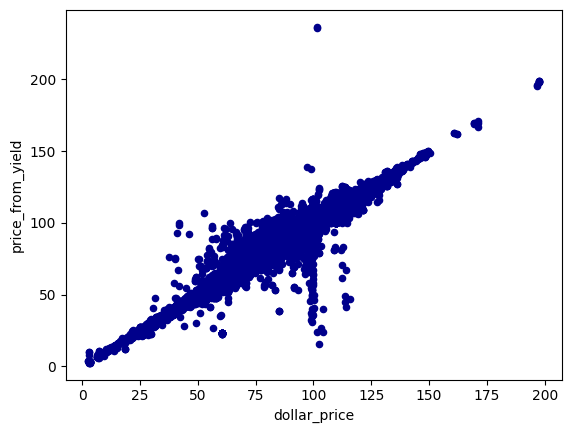

In [11]:
muni_df['price_from_yield'] = [x[0] for x in muni_df['price_calc_from_yield']]
muni_df.plot.scatter(x='dollar_price', y='price_from_yield', c='DarkBlue')


Return the sum and mean of the errors where the error is defined as the absolute distance between our computed price and the reference price.

In [12]:
muni_df['price_delta'] = abs(muni_df['price_from_yield'] - muni_df['dollar_price'])
print(f"Sum of errors: {np.sum(muni_df['price_delta'])}")
print(f"Mean of errors: {np.mean(muni_df['price_delta'])}")

Sum of errors: 1542325.773
Mean of errors: 0.41022651929293164


/var/folders/6s/gj2fjqpx7kd1zydwmjp477dw0000gn/T/ipykernel_19550/1213737055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muni_df['price_delta'] = abs(muni_df['price_from_yield'] - muni_df['dollar_price'])
